In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial as spa
from scipy.stats import multivariate_normal

In [2]:
X = np.genfromtxt("hw08_data_set.csv", delimiter=',')
centroids = np.genfromtxt("hw08_initial_centroids.csv", delimiter=',')
print(X.shape,centroids.shape)

(1000, 2) (9, 2)


In [3]:
N = len(X)
K = centroids.shape[0]
print(N,K)

1000 9


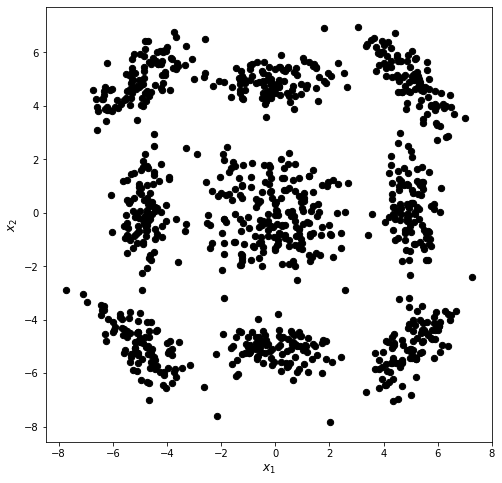

In [4]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=40, color="k")

plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.show()

# EM Algorithm

In [5]:
def initial_memberships(centroids, X):
    D = spa.distance_matrix(centroids, X)
    memberships = np.argmin(D, axis = 0)
    return(memberships)

def initial_covariance_matrices(memberships, centroids, X, K):
    covariance_matrices = [np.sum([(X[memberships == k][i] - centroids[k]).reshape(2, 1) @ (X[memberships == k][i] - centroids[k]).reshape(1, 2)for i in range(len(X[memberships == k]))], axis=0) / len(X[memberships == k]) for k in range(K)]
    return(covariance_matrices)

def initial_prior_probabilities(memberships, X, N):
    prior_probabilities = np.array(pd.Series(memberships).value_counts().sort_index()/N)
    return(prior_probabilities)

In [6]:
memberships = initial_memberships(centroids, X)
covariance_matrices = initial_covariance_matrices(memberships, centroids, X, K)
prior_probabilities = initial_prior_probabilities(memberships, X, N)

In [7]:
print(f"Initial Centroids (Mean Vectors):\n{centroids}\n")
print(f"Initial Memberships:\n{memberships}\n")
print(f"Membership Value Counts:\n{pd.Series(memberships).value_counts()}\n")
print(f"Initial Covariance Matrices:\n{covariance_matrices}\n")
print(f"Initial Prior Probabilities:\n{prior_probabilities}")

Initial Centroids (Mean Vectors):
[[-1.993914 -2.39371 ]
 [-3.229716 -0.175701]
 [-1.801737  2.174948]
 [-1.00894  -3.25249 ]
 [ 0.759302 -0.937463]
 [-1.255211  3.882716]
 [ 3.310545 -1.74418 ]
 [ 2.900411 -0.878848]
 [ 4.122835  3.237119]]

Initial Memberships:
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 5
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 5 5 5 5 2 5 5 5 5 5 2
 5 5 5 5 2 5 2 5 5 2 5 5 2 5 5 5 2 5 5 5 5 5 2 2 2 5 2 5 2 5 5 5 5 5 5 5 5
 2 5 5 5 2 5 5 5 5 5 2 5 5 5 2 5 5 5 5 5 5 2 2 5 5 5 5 5 5 5 5 2 5 5 5 2 2
 5 5 5 2 5 1 5 5 5 5 2 5 5 2 2 0 0 0 0 0 3 3 0 0 3 0 0 0 0 0 0 0 0 3 0 0 0
 0 0 0 0 3 0 0 0 0 0 0 0 0 3 0 0 0 1 0 1 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 3 0 0 0 3 3 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

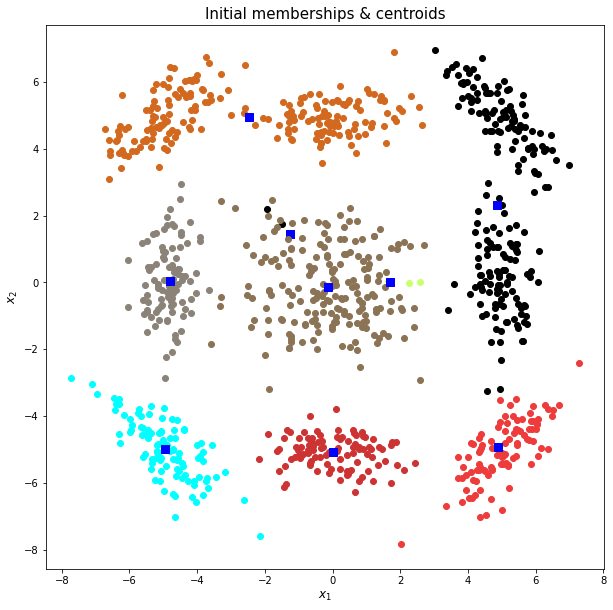

In [25]:
colors = ["#00FFFF", "#8B8378", "#000000", "#CD3333", "#8B7355","#D2691E","#EE3B3B","#CAFF70","#000000"]

plt.figure(figsize=(10, 10))

plt.title("Initial memberships & centroids", fontsize=15)

for i in range(9):
    plt.scatter(X[memberships == i][:, 0], X[memberships == i][:, 1], color=colors[i])
    plt.scatter(centroids[i][0], centroids[i][1], color="b", marker="s", s=50)

plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.show()

In [9]:
def multivariate_gaussian(x, mean, covariance):
    return (1. / (np.sqrt((2 * np.pi)**2 * np.linalg.det(covariance))) *  np.exp(-(np.linalg.solve(covariance, x - mean).T.dot(x - mean)) / 2))
def mixture_density(x, mean, covariance, prior_probability):
    return multivariate_gaussian(x, mean, covariance) * prior_probability
def h_ik(x, centroids, covariance_matrices, prior_probabilities):
    return [mixture_density(x, centroids[k], covariance_matrices[k], prior_probabilities[k]) / np.sum([mixture_density(x, centroids[i], covariance_matrices[i], prior_probabilities[i]) for i in range(K)]) for k in range(K)]

## E Step

In [10]:
def find_memberships(X, centroids, covariance_matrices, prior_probabilities):
    memberships = []

    for m in range(N):
        posterior_probabilities = h_ik(X[m], centroids, covariance_matrices, prior_probabilities)
        max_value = max(posterior_probabilities)
        max_index = posterior_probabilities.index(max_value)
        memberships.append(max_index)
    return np.array((memberships))

## M Step 

In [11]:
def update_centroids(memberships, X):
    return np.vstack([np.sum([h_ik(X[memberships == k][i], centroids, covariance_matrices, prior_probabilities)[k] * X[memberships == k][i] for i in range(len(X[memberships == k]))], axis=0) / len(X[memberships == k]) for k in range(K)])

def update_covariance_matrices(memberships, centroids, X, K):
    return [np.sum([h_ik(X[memberships == k][i], centroids, covariance_matrices, prior_probabilities)[k] * (X[memberships == k][i] - centroids[k]).reshape(2, 1) @ (X[memberships == k][i] - centroids[k]).reshape(1, 2) for i in range(len(X[memberships == k]))], axis=0) / len(X[memberships == k]) for k in range(K)]
    
def update_prior_probabilities(memberships, X, N):
    return np.array(pd.Series(memberships).value_counts().sort_index()/N)

## Run For 100 Iterations

In [12]:
for iteration in range(50):
    memberships = find_memberships(X, centroids, covariance_matrices, prior_probabilities)
    centroids = update_centroids(memberships, X)
    covariance_matrices = update_covariance_matrices(memberships, centroids, X, K)
    prior_probabilities = update_prior_probabilities(memberships, X, N)

print(f"Mean vectors after 50 iterations:\n\n{centroids}")
#at 100 iterations, the algorithm gives runtime error and I could not solve it. That's why I run it with 50 iterations.

Mean vectors after 100 iterations:

[[-4.94581273 -4.98057653]
 [-4.80939308  0.03689707]
 [-1.26609637  1.44766845]
 [ 0.02637782 -5.07542467]
 [-0.12329625 -0.14189231]
 [-2.47517992  4.95147357]
 [ 4.88230236 -4.92957136]
 [ 1.68869191  0.00791206]
 [ 4.84556696  2.32040417]]


## Visualization

In [15]:
initial_means = np.array([[+5, +5],
                          [-5, +5],
                          [-5, +5],
                          [+5, -5],
                          [+5, +0.0],
                          [+0.0, +5],
                          [-5.0, +0.0],
                          [+0.0, -5],
                          [0.0, 0.0]])

initial_covariances = np.array([[[+0.8, -0.6], [-0.6, +0.8]],
                                [[+0.8, +0.6], [+0.6, +0.8]],
                                [[+0.8, -0.6], [-0.6, +0.8]],
                                [[+0.8, +0.6], [+0.6, +0.8]],
                                [[+0.2, +0.0], [+0.0, +1.2]],
                                [[+1.2, +0.0], [+0.0, +0.2]],
                                [[+0.2, +0.0], [+0.0, +1.2]],
                                [[+1.2, +0.0], [+0.0, +0.2]],
                                [[+1.6, +0.0], [+0.0, +1.6]],])

x, y = np.mgrid[-6:+6:.05, -6:+6:.05]
pos = np.dstack((x, y))

original_gausses = [multivariate_normal(mean=initial_means[i], cov=initial_covariances[i]*2) for i in range(9)]
found_gausses = [multivariate_normal(mean=centroids[i], cov=covariance_matrices[i]*2) for i in range(9)]

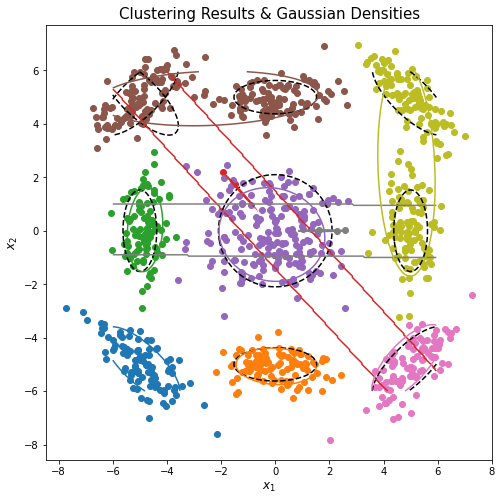

In [16]:
plt.figure(figsize=(8, 8))

plt.title("Clustering Results & Gaussian Densities", fontsize=15)

for original_gauss in original_gausses:
    plt.contour(x, y, original_gauss.pdf(pos), levels=1, linestyles="dashed", colors="k")
for i, found_gauss in enumerate(found_gausses):
    plt.contour(x, y, found_gauss.pdf(pos), levels=1, colors=colors[i])
for i in range(9):
    plt.scatter(X[memberships == i][:, 0], X[memberships == i][:, 1], color=colors[i])
    
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.show()